## Dataset Downloading

In [1]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"navinbondade23","key":"1e8e85d548f349b67f2e015da44880bd"}'}

In [3]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

 99% 424M/428M [00:17<00:00, 31.4MB/s]
100% 428M/428M [00:17<00:00, 26.2MB/s]


In [4]:
#unziping the file
from zipfile import ZipFile
file_name = '/content/toronto-emotional-speech-set-tess.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


## Importing The Libraries

In [5]:
from IPython.display import display
import IPython
import os, pandas as pd, librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from sklearn.metrics import classification_report,confusion_matrix

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Embedding, Dropout, Conv1D, BatchNormalization, Activation, MaxPooling1D, GlobalMaxPooling1D, LSTM
from tensorflow.keras.optimizers import Adam, SGD
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

In [7]:
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

## Creating The CSV

In [8]:
dataset = pd.DataFrame(columns=['Path', 'Audio', "MFCCS", 'Label'])

## Preparing The Data

In [9]:
path = '/content/Emotions'
dirs = os.listdir(path)
dirs_list = []
for i in dirs:
  if i[:3]=='OAF':
    dirs_list.append(i)

mfccs_list = []

In [10]:
i = 0 
for folder in tqdm(dirs_list):
  for filename in os.listdir(path+f'/{folder}'):
    if filename.endswith(".wav"):
      try:
        folder_name = folder
        path_audio = f'{path}/{folder_name}/{filename}'
        librosa_audio_data, librosa_sample_rate = librosa.load(path_audio)
        mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
        dataset.loc[i] = [path+f'/{folder_name}', filename , mfccs, folder_name]
        mfccs_array = np.array(mfccs)
        mfccs_list.append(mfccs_array)
        i = i+1
      except:
        pass  
  print(f'{folder_name}: Files Done')

 14%|█▍        | 1/7 [00:15<01:32, 15.47s/it]

OAF_angry: Files Done


 29%|██▊       | 2/7 [00:30<01:17, 15.40s/it]

OAF_Fear: Files Done


 43%|████▎     | 3/7 [00:48<01:05, 16.25s/it]

OAF_neutral: Files Done


 57%|█████▋    | 4/7 [01:09<00:52, 17.65s/it]

OAF_disgust: Files Done


 71%|███████▏  | 5/7 [01:28<00:35, 17.87s/it]

OAF_Pleasant_surprise: Files Done


 86%|████████▌ | 6/7 [01:46<00:17, 18.00s/it]

OAF_happy: Files Done


100%|██████████| 7/7 [02:08<00:00, 18.41s/it]

OAF_Sad: Files Done


## Displaying The Data

In [12]:
dataset.to_csv('Audio_Data.csv')
display(dataset.sample(6))

Path  ...        Label
1202      /content/Emotions/OAF_Sad  ...      OAF_Sad
27      /content/Emotions/OAF_angry  ...    OAF_angry
1153    /content/Emotions/OAF_happy  ...    OAF_happy
1099    /content/Emotions/OAF_happy  ...    OAF_happy
1188    /content/Emotions/OAF_happy  ...    OAF_happy
573   /content/Emotions/OAF_neutral  ...  OAF_neutral

[6 rows x 4 columns]

## Preparing The Data



In [13]:
#extracting the audio sample for each class
Angry = f"{dataset[dataset['Label']=='OAF_angry'].Path.iloc[0]}/{dataset[dataset['Label']=='OAF_angry'].Audio.iloc[0]}"
Happy = f"{dataset[dataset['Label']=='OAF_happy'].Path.iloc[0]}/{dataset[dataset['Label']=='OAF_happy'].Audio.iloc[0]}"
Neutral = f"{dataset[dataset['Label']=='OAF_neutral'].Path.iloc[0]}/{dataset[dataset['Label']=='OAF_neutral'].Audio.iloc[0]}"
Sad = f"{dataset[dataset['Label']=='OAF_Sad'].Path.iloc[0]}/{dataset[dataset['Label']=='OAF_Sad'].Audio.iloc[0]}"
Fearful = f"{dataset[dataset['Label']=='OAF_Fear'].Path.iloc[0]}/{dataset[dataset['Label']=='OAF_Fear'].Audio.iloc[0]}"
Disgusted = f"{dataset[dataset['Label']=='OAF_disgust'].Path.iloc[0]}/{dataset[dataset['Label']=='OAF_disgust'].Audio.iloc[0]}"
Suprised = f"{dataset[dataset['Label']=='OAF_Pleasant_surprise'].Path.iloc[0]}/{dataset[dataset['Label']=='OAF_Pleasant_surprise'].Audio.iloc[0]}"

##Recording Of Different Emotions In Speech

####Angry Audio Recording

In [14]:
from IPython.display import Audio 
Audio(Angry, autoplay=True)

####Happy Audio Recording

In [15]:
Audio(Happy, autoplay=True)

####Neutral Audio Recording

In [16]:
Audio(Neutral, autoplay=True)

####Fearful Audio Recording

In [17]:
Audio(Fearful, autoplay=True)

####Disgusted Audio Recording

In [18]:
Audio(Disgusted, autoplay=True)

####Surprise Audio Recording

In [19]:
Audio(Suprised, autoplay=True)

## Audio Analysis

In [20]:
#getting audio time series and sample rate for each series
Angry_librosa_audio_data, Angry_librosa_sample_rate = librosa.load(Angry)
Happy_librosa_audio_data, Happy_librosa_sample_rate = librosa.load(Happy)
Neutral_librosa_audio_data, Neutral_librosa_sample_rate = librosa.load(Neutral)
Sad_librosa_audio_data, Sad_librosa_sample_rate = librosa.load(Sad)
Fearful_librosa_audio_data, Fearful_librosa_sample_rate = librosa.load(Fearful)
Disgusted_librosa_audio_data, Disgusted_librosa_sample_rate = librosa.load(Disgusted)
Suprised_librosa_audio_data, Suprised_librosa_sample_rate = librosa.load(Suprised)

## Wave Plot For All 7 Different Types Of Emotions

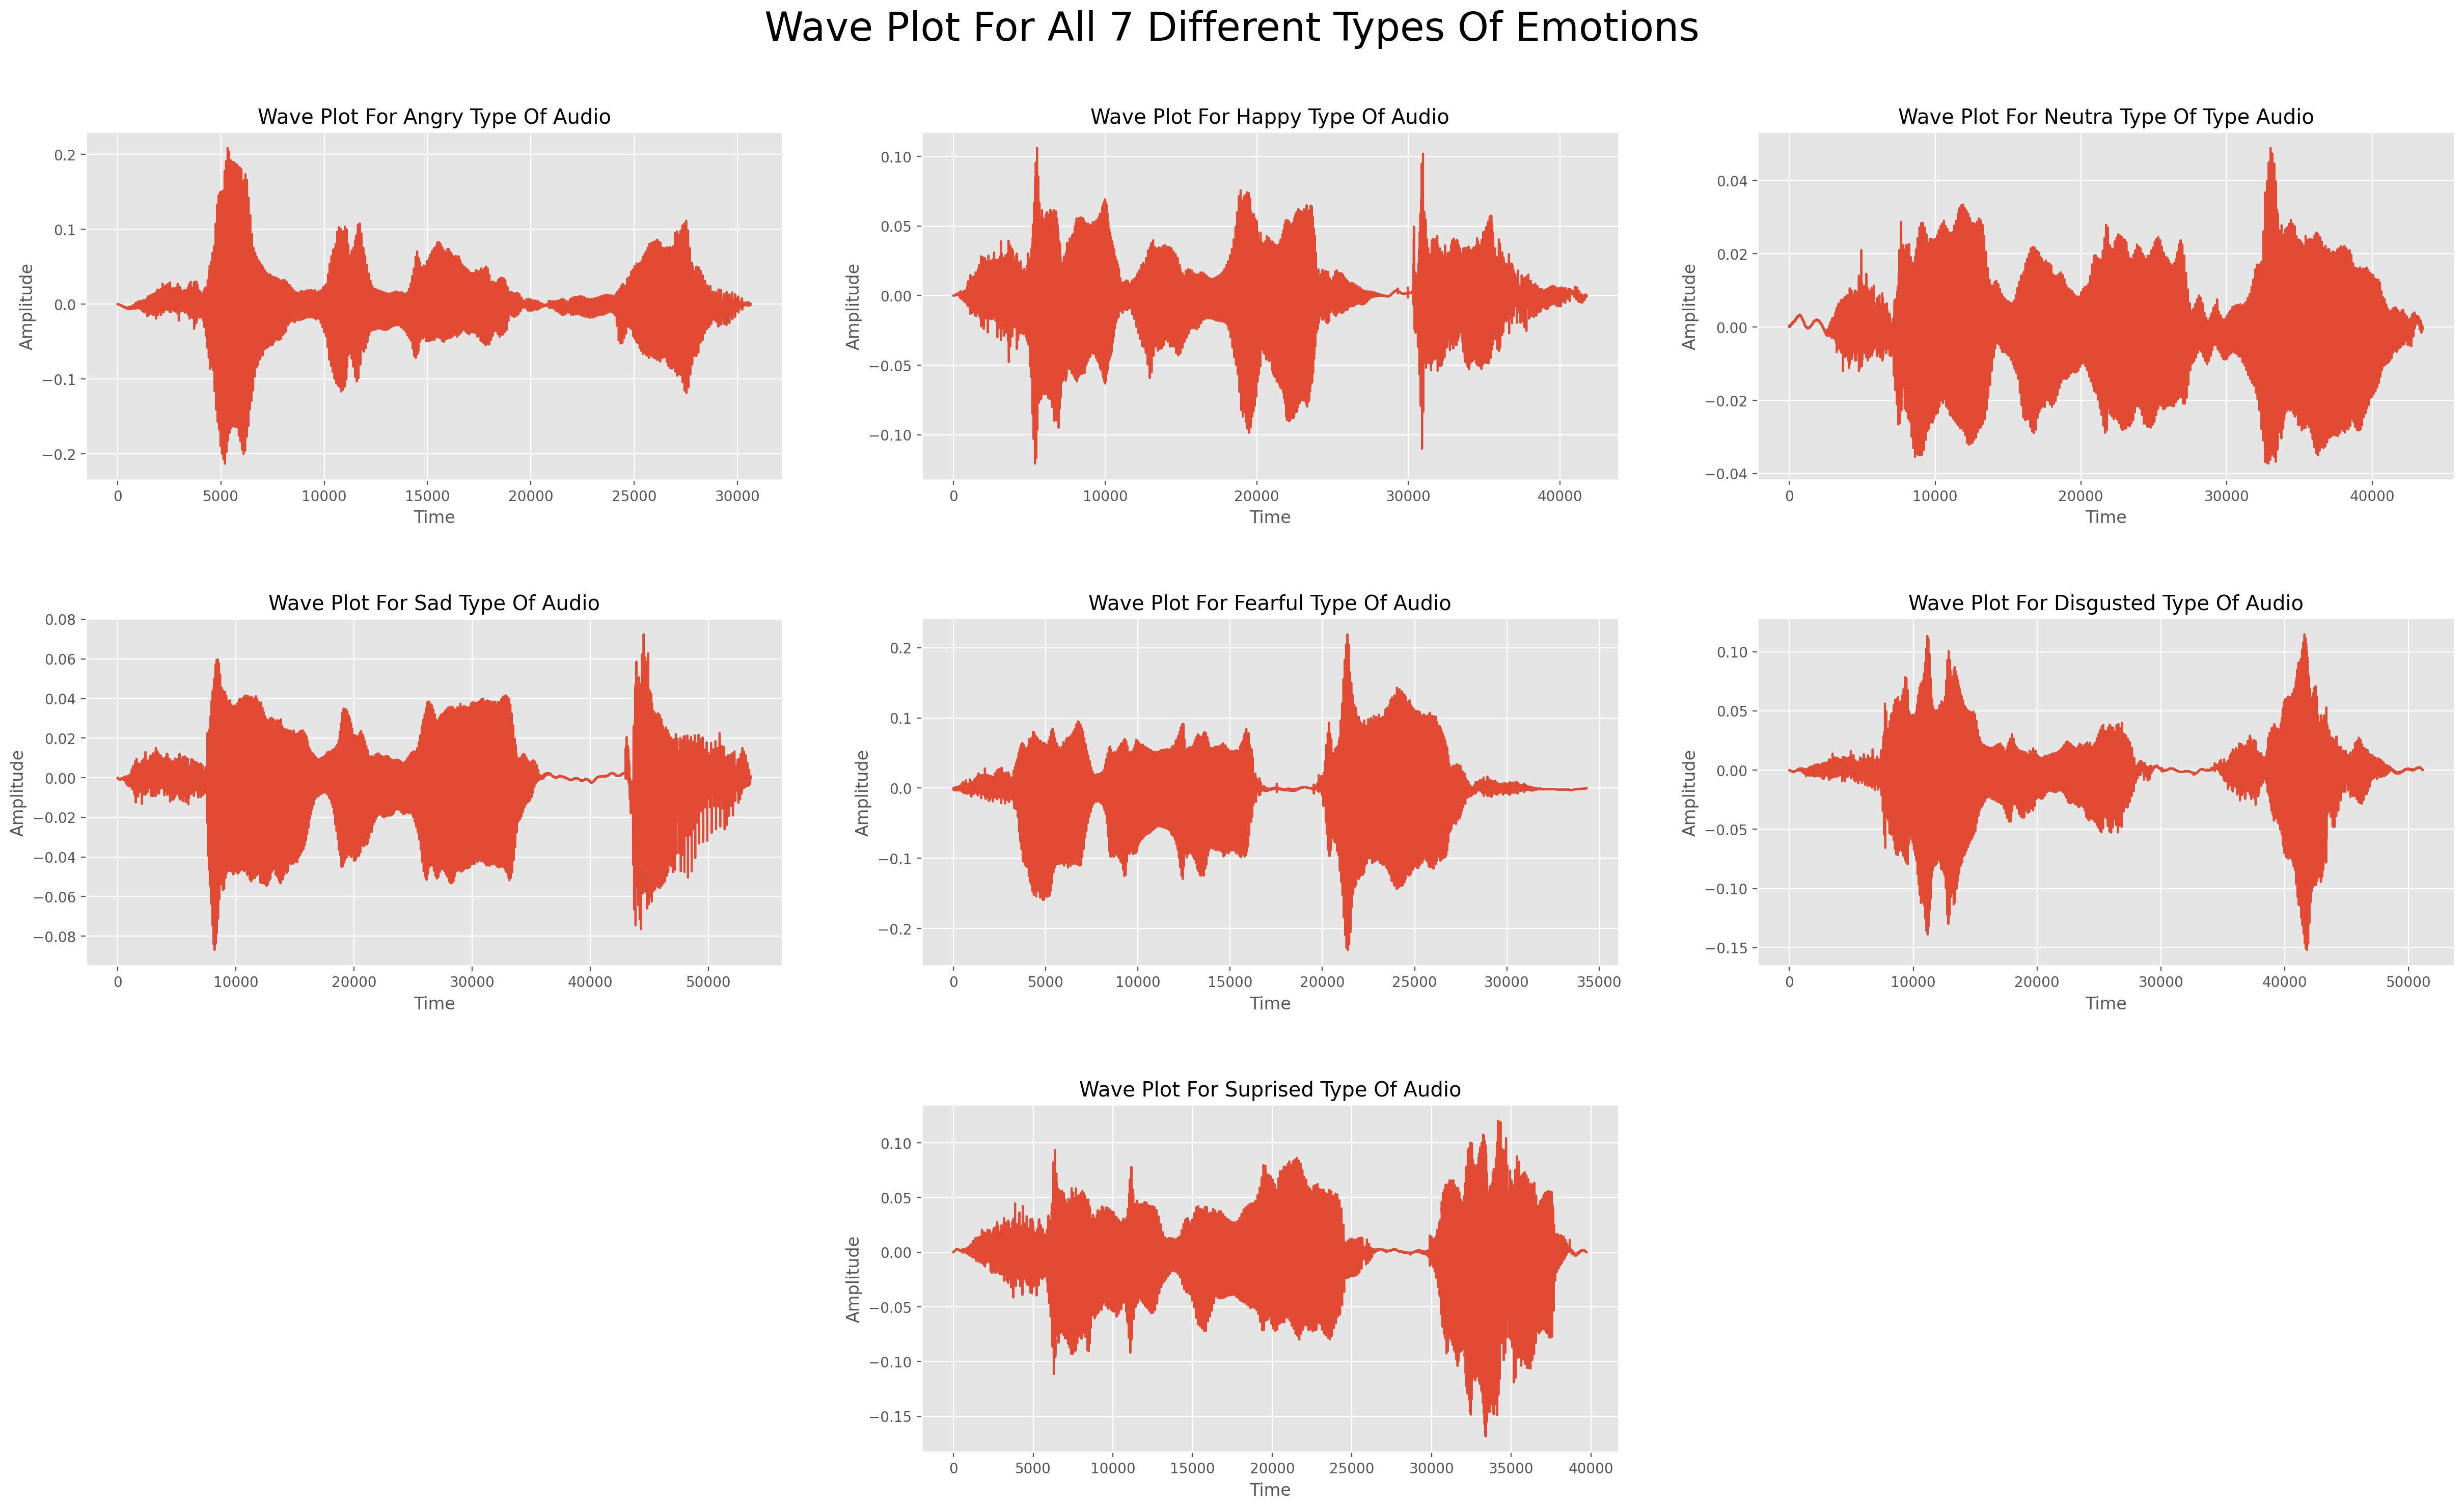

In [21]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams["figure.figsize"] = (30,12)

fig, axs = plt.subplots(3, 3)

axs[0, 0].plot(Angry_librosa_audio_data)
axs[0, 0].set_title('Wave Plot For Angry Type Of Audio')

axs[0, 1].plot(Happy_librosa_audio_data)
axs[0, 1].set_title('Wave Plot For Happy Type Of Audio')

axs[0, 2].plot(Neutral_librosa_audio_data)
axs[0, 2].set_title('Wave Plot For Neutra Type Of Type Audio')


axs[1, 0].plot(Sad_librosa_audio_data)
axs[1, 0].set_title('Wave Plot For Sad Type Of Audio')

axs[1, 1].plot(Fearful_librosa_audio_data)
axs[1, 1].set_title('Wave Plot For Fearful Type Of Audio')

axs[1, 2].plot(Disgusted_librosa_audio_data)
axs[1, 2].set_title('Wave Plot For Disgusted Type Of Audio')

axs[2, 0].set_visible(False)
axs[2, 2].set_visible(False)

axs[2, 1].plot(Suprised_librosa_audio_data)
axs[2, 1].set_title('Wave Plot For Suprised Type Of Audio')


fig.subplots_adjust(bottom=-0.2)
plt.setp(axs[:], xlabel='Time')
plt.setp(axs[:], ylabel='Amplitude')
fig.suptitle('Wave Plot For All 7 Different Types Of Emotions', fontsize=28)

plt.subplots_adjust(wspace=0.2, hspace=.4)
plt.show()

## Spectrogram For All 7 Different Types Of Emotions

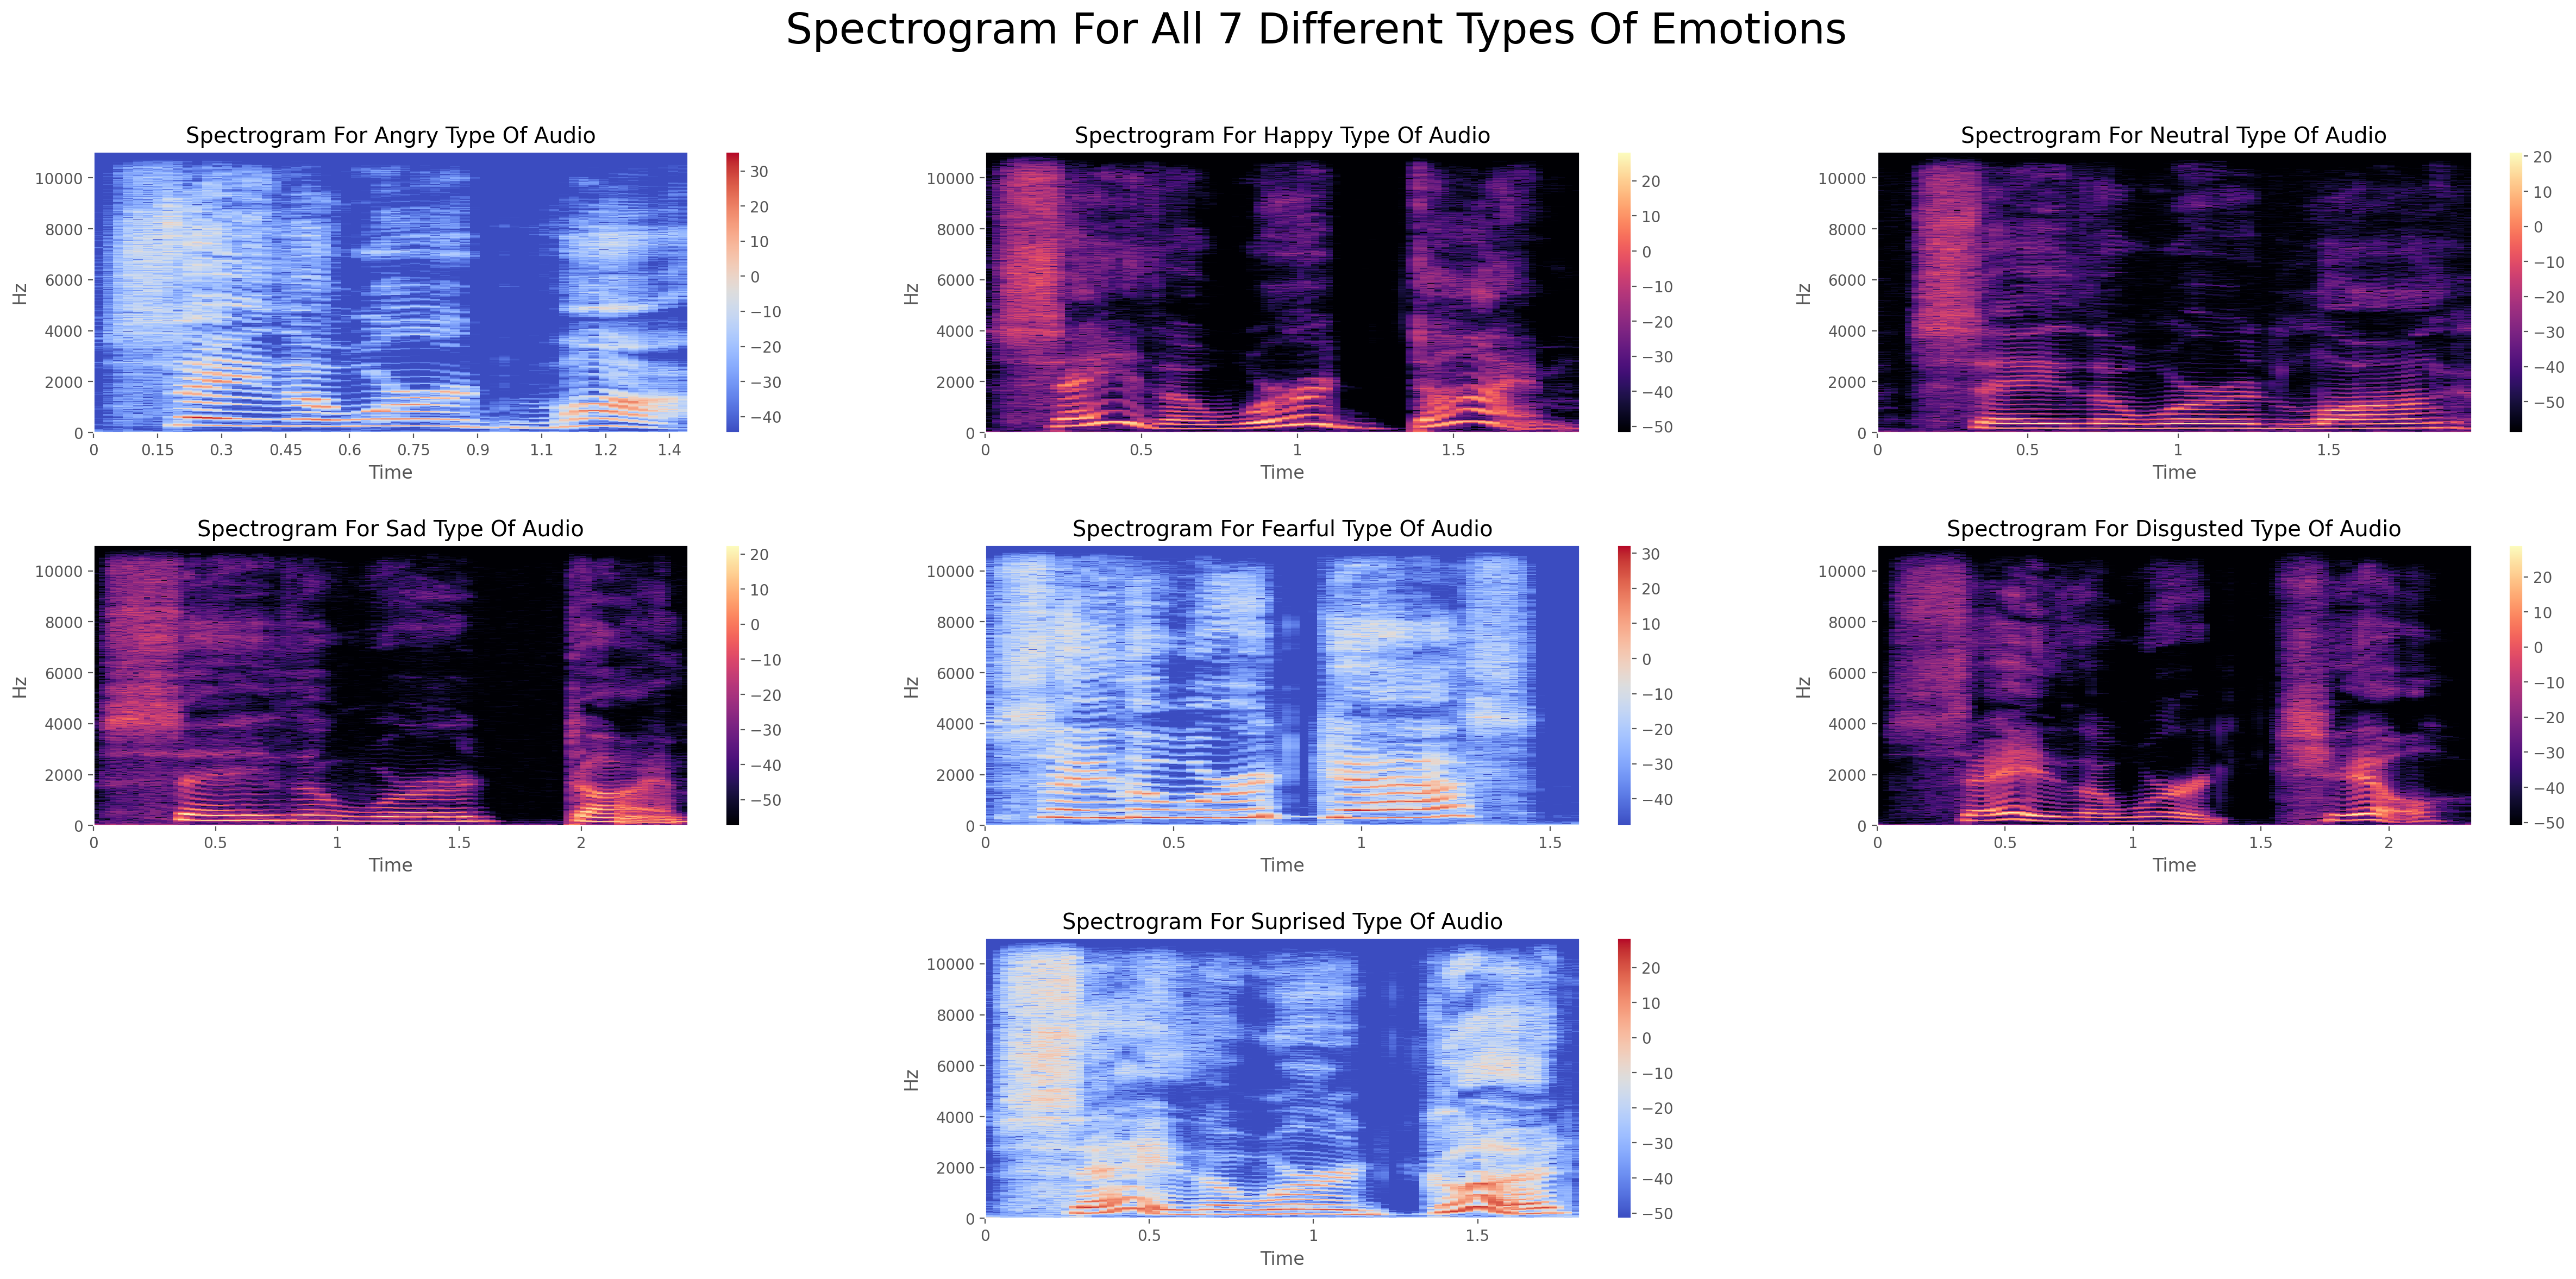

In [22]:
plt.rcParams["figure.figsize"] = (30,13)
plt.rcParams['figure.dpi'] = 200


ax = plt.subplot(3,3,1)
X = librosa.stft(Angry_librosa_audio_data)
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=Angry_librosa_sample_rate, x_axis='time', y_axis='hz')
plt.title('Spectrogram For Angry Type Of Audio')
plt.colorbar()

ax = plt.subplot(3,3,2)
X = librosa.stft(Happy_librosa_audio_data)
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=Happy_librosa_sample_rate, x_axis='time', y_axis='hz')
plt.title('Spectrogram For Happy Type Of Audio')
plt.colorbar()

ax = plt.subplot(3,3,3)
X = librosa.stft(Neutral_librosa_audio_data)
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=Neutral_librosa_sample_rate, x_axis='time', y_axis='hz')
plt.title('Spectrogram For Neutral Type Of Audio')
plt.colorbar()

ax = plt.subplot(3,3,4)
X = librosa.stft(Sad_librosa_audio_data)
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=Sad_librosa_sample_rate, x_axis='time', y_axis='hz')
plt.title('Spectrogram For Sad Type Of Audio')
plt.colorbar()


ax = plt.subplot(3,3,5)
X = librosa.stft(Fearful_librosa_audio_data)
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=Fearful_librosa_sample_rate, x_axis='time', y_axis='hz')
plt.title('Spectrogram For Fearful Type Of Audio')
plt.colorbar()

ax = plt.subplot(3,3,6)
X = librosa.stft(Disgusted_librosa_audio_data)
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=Disgusted_librosa_sample_rate, x_axis='time', y_axis='hz')
plt.title('Spectrogram For Disgusted Type Of Audio')
plt.colorbar()

ax = plt.subplot(3,3,8)
X = librosa.stft(Suprised_librosa_audio_data)
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=Suprised_librosa_sample_rate, x_axis='time', y_axis='hz')
plt.title('Spectrogram For Suprised Type Of Audio')
plt.colorbar()

plt.subplots_adjust(wspace=0.2, hspace=.4)
plt.suptitle("Spectrogram For All 7 Different Types Of Emotions", fontsize=28)
plt.show()

## MFCCS For All 7 Different Types Of Emotions

In [23]:
Angry_mfccs = dataset[dataset['Label']=='OAF_angry'].MFCCS.iloc[0]
Happy_mfccs = dataset[dataset['Label']=='OAF_happy'].MFCCS.iloc[0]
Neutral_mfccs = dataset[dataset['Label']=='OAF_neutral'].MFCCS.iloc[0]
Sad_mfccs = dataset[dataset['Label']=='OAF_Sad'].MFCCS.iloc[0]
Fearful_mfccs = dataset[dataset['Label']=='OAF_Fear'].MFCCS.iloc[0]
Disgusted_mfccs = dataset[dataset['Label']=='OAF_disgust'].MFCCS.iloc[0]
Suprised_mfccs = dataset[dataset['Label']=='OAF_Pleasant_surprise'].MFCCS.iloc[0]

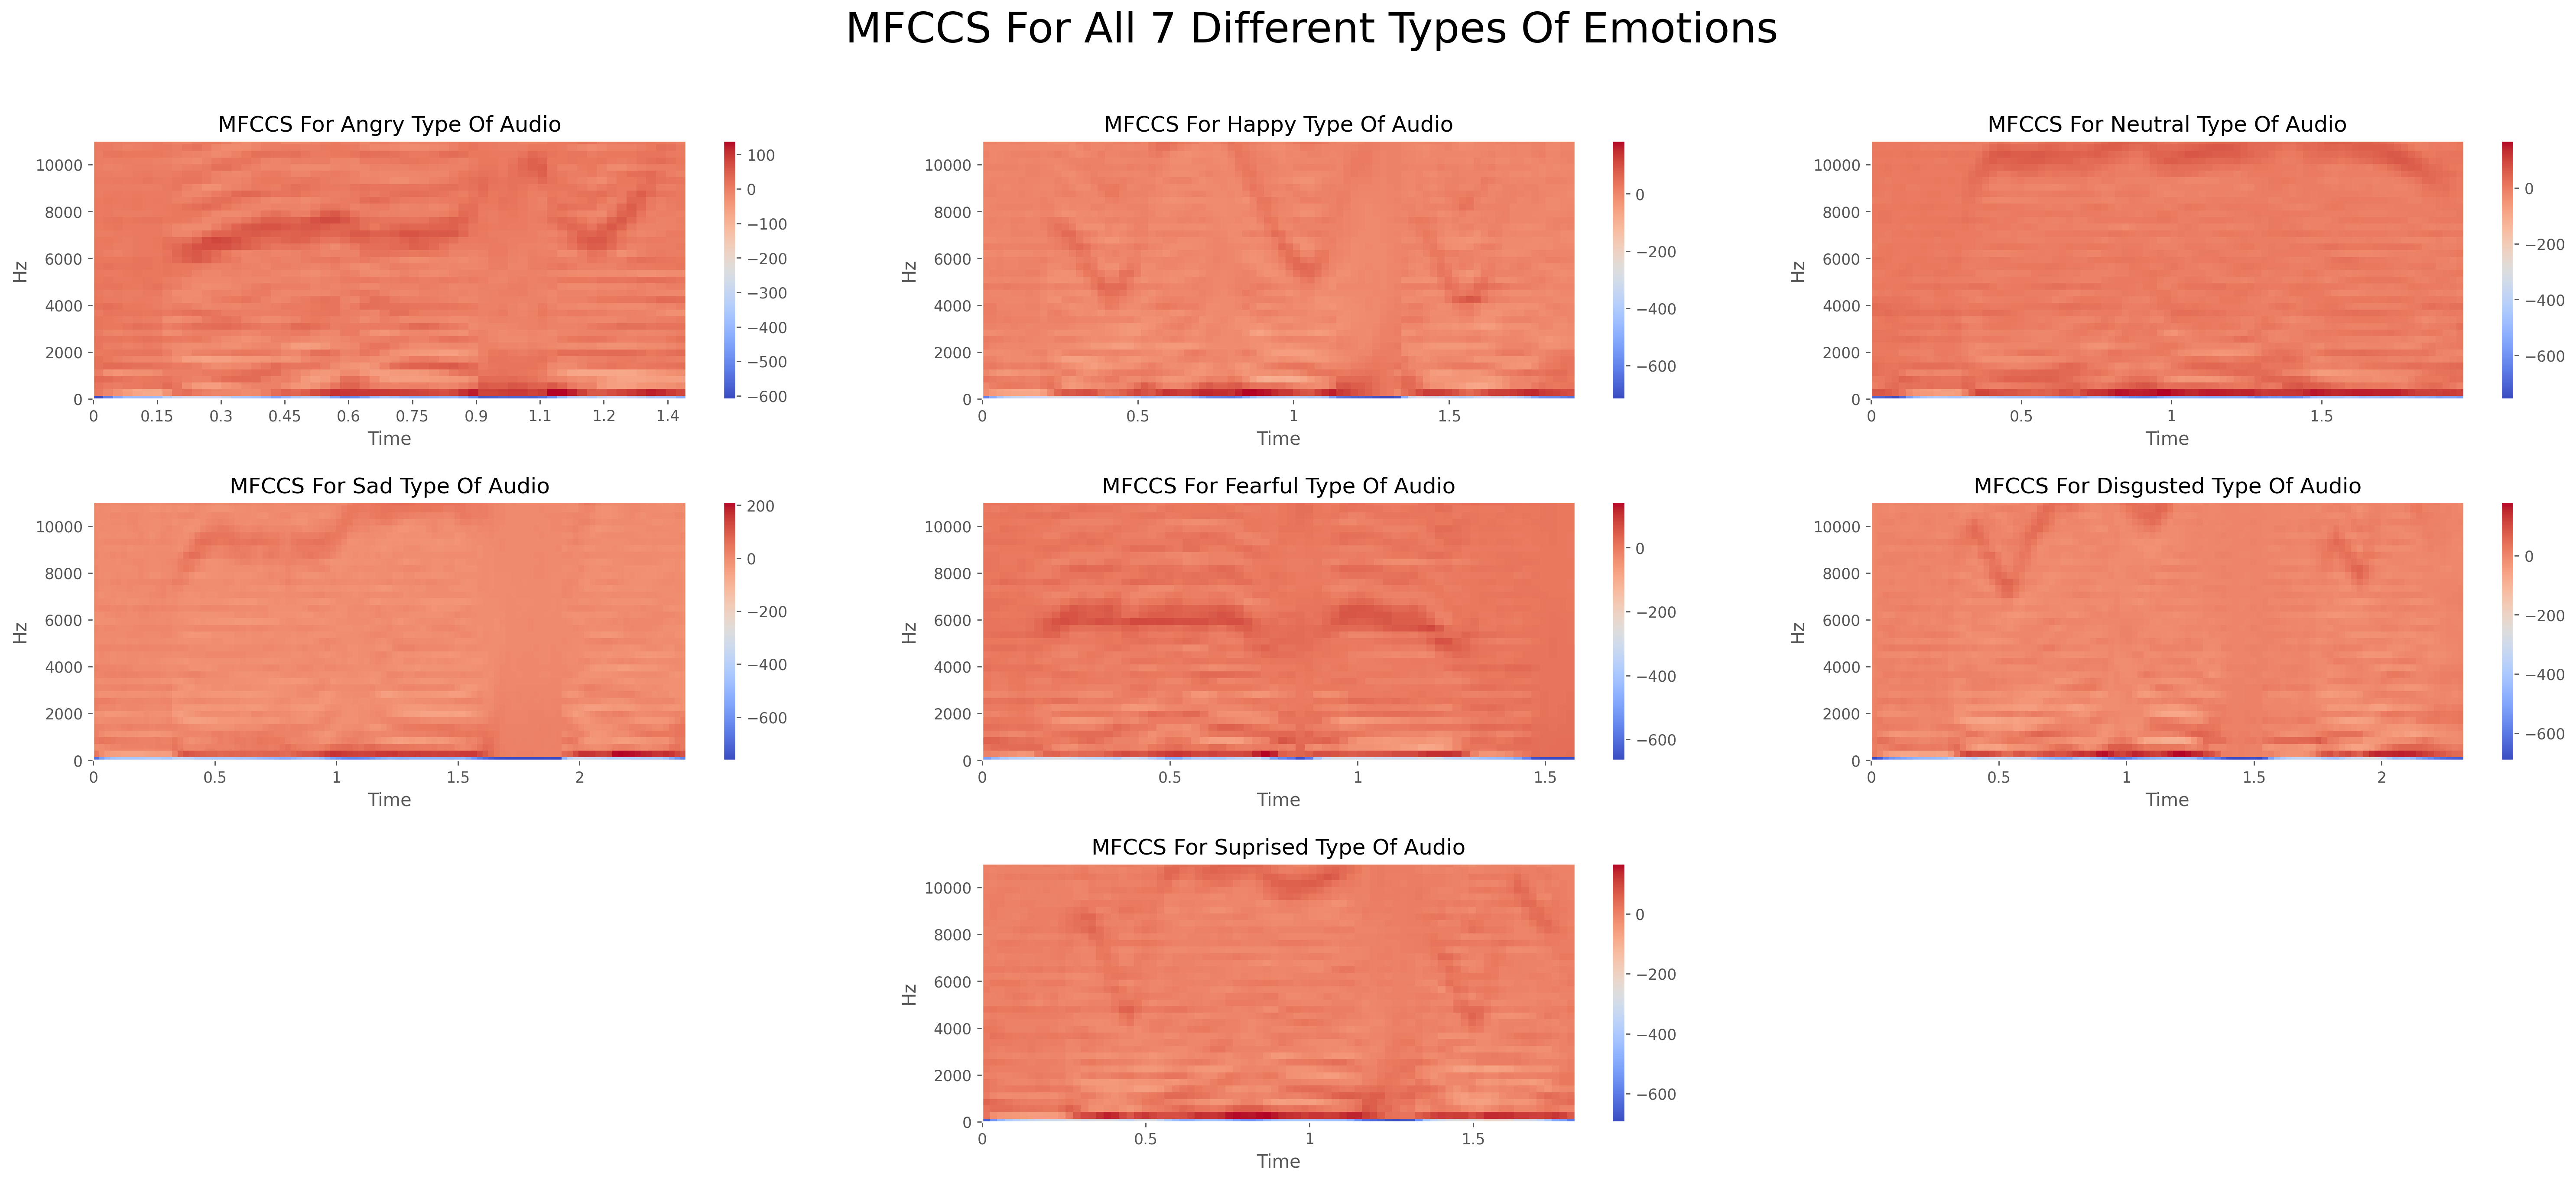

In [24]:
plt.rcParams["figure.figsize"] = (30,12)
plt.rcParams['figure.dpi'] = 250


ax = plt.subplot(3,3,1)
librosa.display.specshow(Angry_mfccs, sr=Angry_librosa_sample_rate, x_axis='time', y_axis='hz')
plt.title('MFCCS For Angry Type Of Audio')
plt.colorbar()

ax = plt.subplot(3,3,2)
librosa.display.specshow(Happy_mfccs, sr=Happy_librosa_sample_rate, x_axis='time', y_axis='hz')
plt.title('MFCCS For Happy Type Of Audio')
plt.colorbar()

ax = plt.subplot(3,3,3)
librosa.display.specshow(Neutral_mfccs, sr=Neutral_librosa_sample_rate, x_axis='time', y_axis='hz')
plt.title('MFCCS For Neutral Type Of Audio')
plt.colorbar()

ax = plt.subplot(3,3,4)
librosa.display.specshow(Sad_mfccs, sr=Sad_librosa_sample_rate, x_axis='time', y_axis='hz')
plt.title('MFCCS For Sad Type Of Audio')
plt.colorbar()

ax = plt.subplot(3,3,5)
librosa.display.specshow(Fearful_mfccs, sr=Fearful_librosa_sample_rate, x_axis='time', y_axis='hz')
plt.title('MFCCS For Fearful Type Of Audio')
plt.colorbar()

ax = plt.subplot(3,3,6)
librosa.display.specshow(Disgusted_mfccs, sr=Disgusted_librosa_sample_rate, x_axis='time', y_axis='hz')
plt.title('MFCCS For Disgusted Type Of Audio')
plt.colorbar()

ax = plt.subplot(3,3,8)
librosa.display.specshow(Suprised_mfccs, sr=Suprised_librosa_sample_rate, x_axis='time', y_axis='hz')
plt.title('MFCCS For Suprised Type Of Audio')
plt.colorbar()


plt.subplots_adjust(hspace=.4)
plt.suptitle("MFCCS For All 7 Different Types Of Emotions", fontsize=28)
plt.show()

## Chromagram For All 7 Different Types Of Emotions

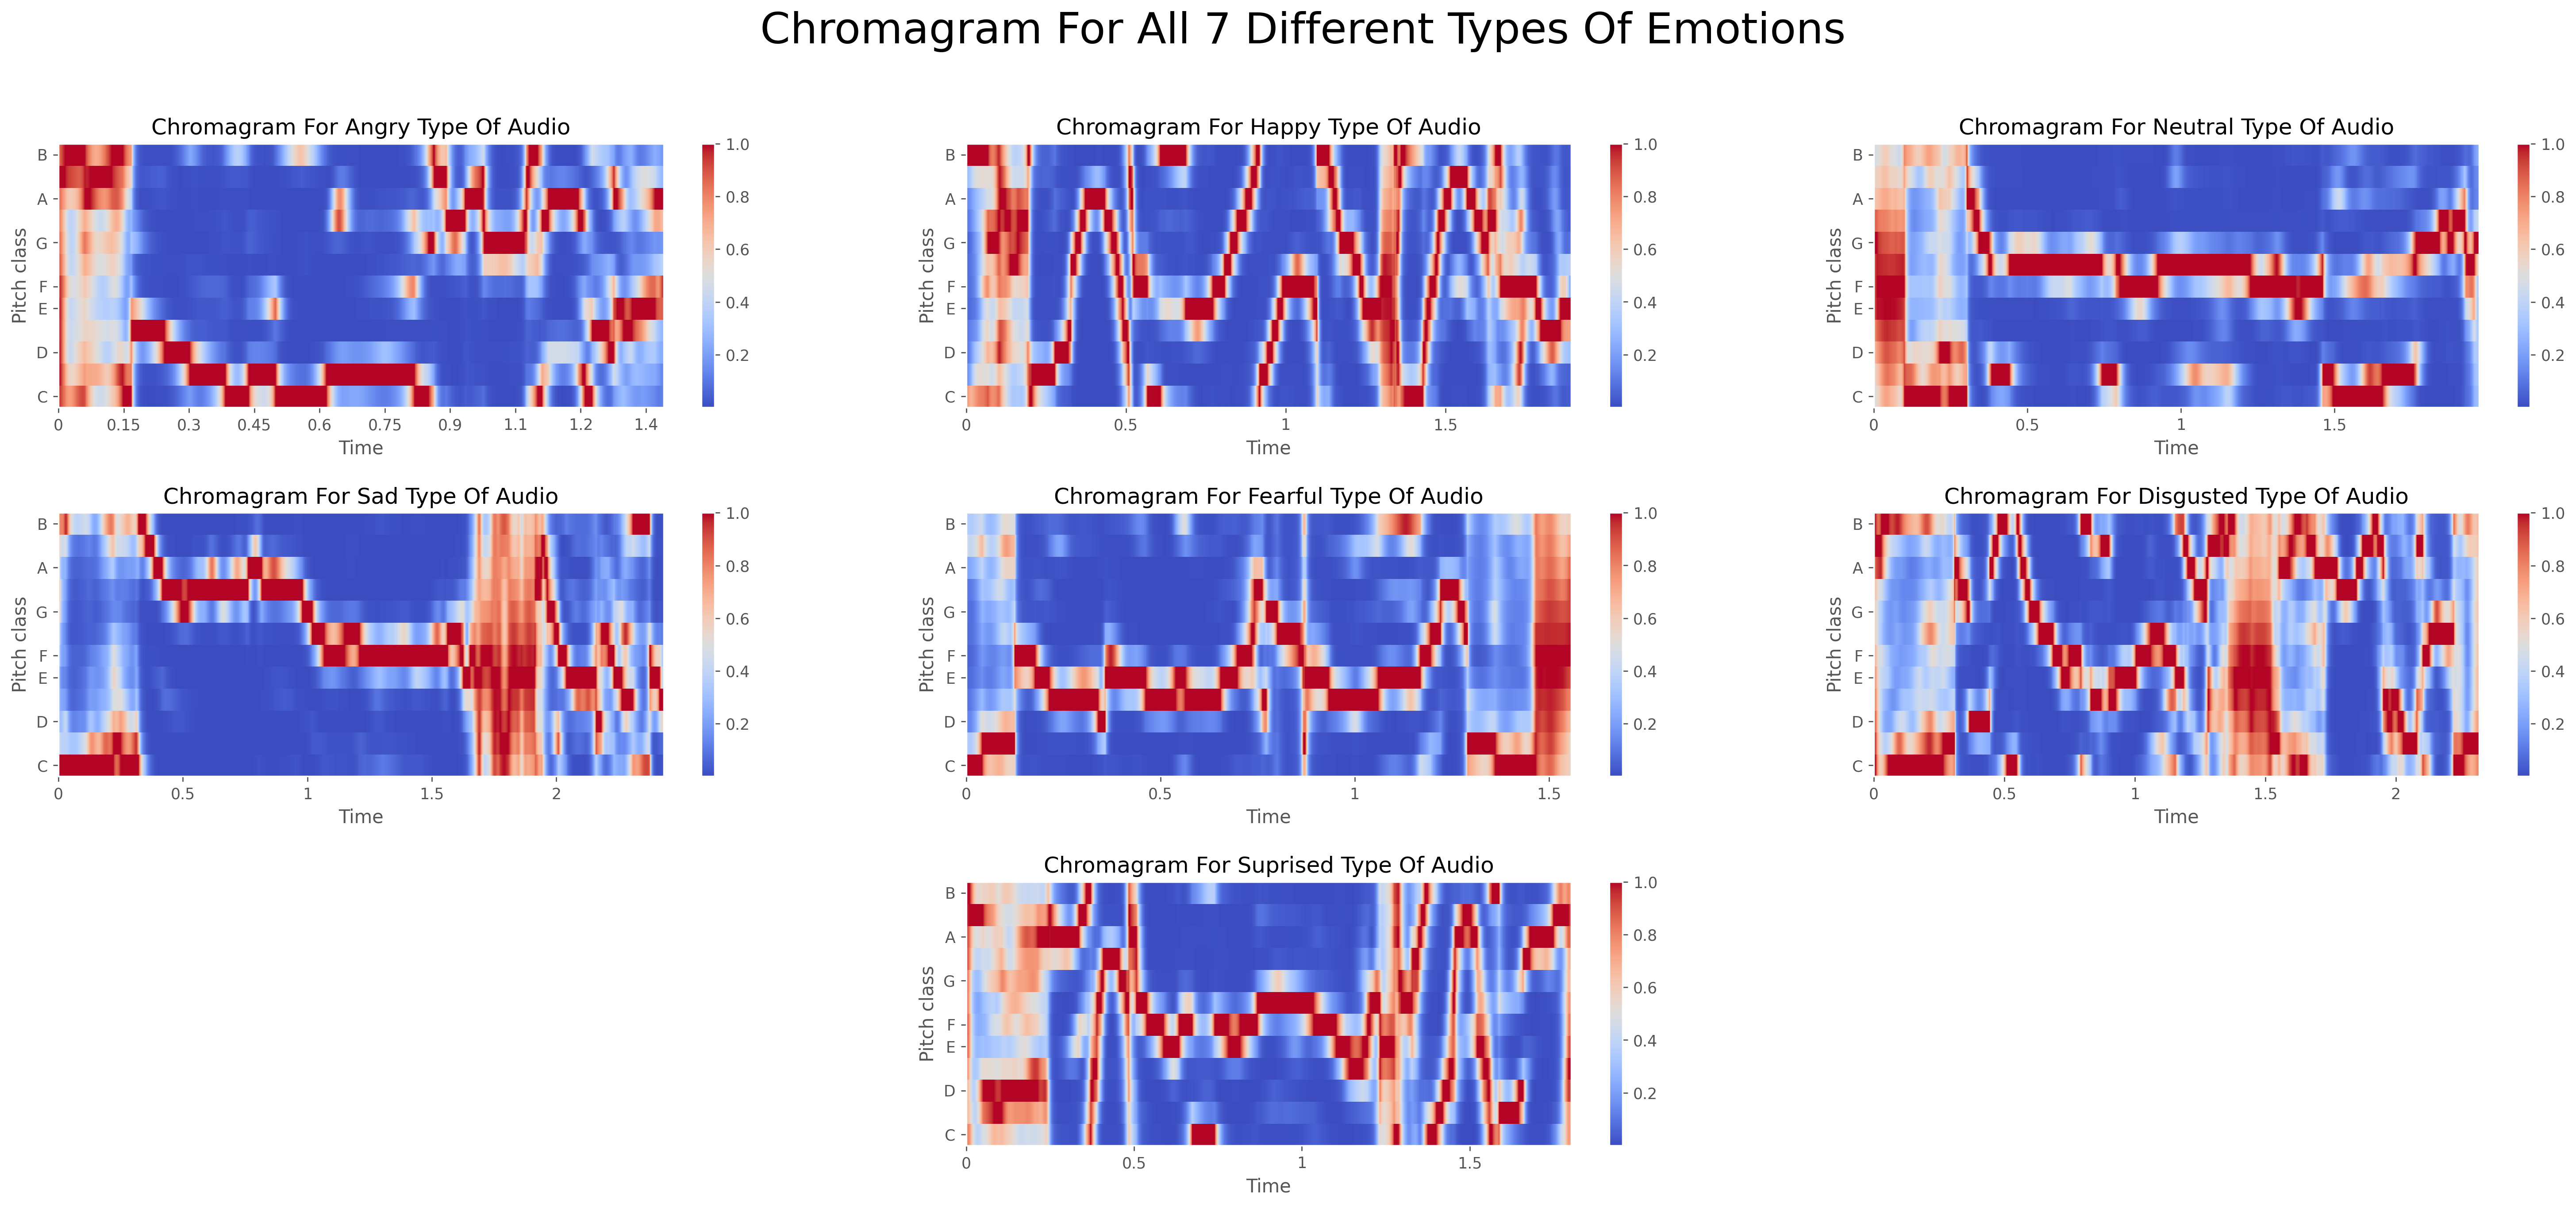

In [25]:
hop_length=12

ax = plt.subplot(3,3,1)
chromagram = librosa.feature.chroma_stft(Angry_librosa_audio_data, sr=Angry_librosa_sample_rate, hop_length=hop_length)
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
plt.title('Chromagram For Angry Type Of Audio')
plt.colorbar()

ax = plt.subplot(3,3,2)
chromagram = librosa.feature.chroma_stft(Happy_librosa_audio_data, sr=Happy_librosa_sample_rate, hop_length=hop_length)
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
plt.title('Chromagram For Happy Type Of Audio')
plt.colorbar()

ax = plt.subplot(3,3,3)
chromagram = librosa.feature.chroma_stft(Neutral_librosa_audio_data, sr=Neutral_librosa_sample_rate, hop_length=hop_length)
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
plt.title('Chromagram For Neutral Type Of Audio')
plt.colorbar()

ax = plt.subplot(3,3,4)
chromagram = librosa.feature.chroma_stft(Sad_librosa_audio_data, sr=Sad_librosa_sample_rate, hop_length=hop_length)
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
plt.title('Chromagram For Sad Type Of Audio')
plt.colorbar()

ax = plt.subplot(3,3,5)
chromagram = librosa.feature.chroma_stft(Fearful_librosa_audio_data, sr=Fearful_librosa_sample_rate, hop_length=hop_length)
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
plt.title('Chromagram For Fearful Type Of Audio')
plt.colorbar()

ax = plt.subplot(3,3,6)
chromagram = librosa.feature.chroma_stft(Disgusted_librosa_audio_data, sr=Disgusted_librosa_sample_rate, hop_length=hop_length)
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
plt.title('Chromagram For Disgusted Type Of Audio')
plt.colorbar()

ax = plt.subplot(3,3,8)
chromagram = librosa.feature.chroma_stft(Suprised_librosa_audio_data, sr=Suprised_librosa_sample_rate, hop_length=hop_length)
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
plt.title('Chromagram For Suprised Type Of Audio')
plt.colorbar()

plt.subplots_adjust(wspace=0.2, hspace=.4)
plt.suptitle("Chromagram For All 7 Different Types Of Emotions", fontsize=28)
plt.show()

## Target Class Data Distribution Visualization

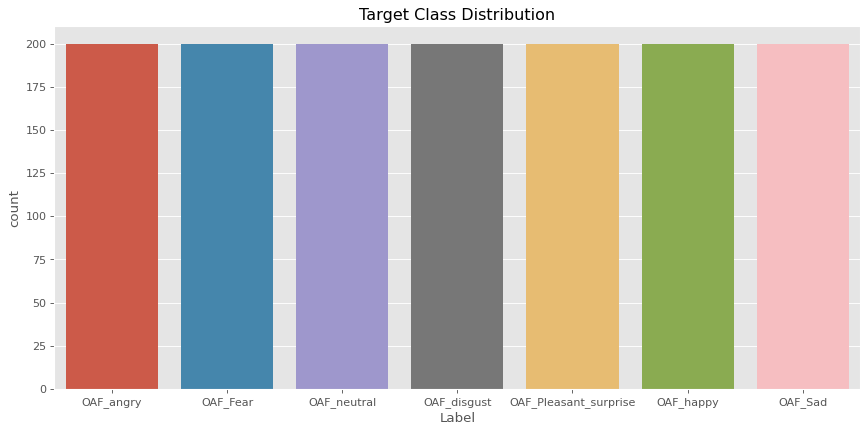

In [26]:
plt.rcParams['figure.figsize'] = [13,6]
plt.rcParams['figure.dpi'] = 80
sns.countplot('Label', data=dataset)
plt.title('Target Class Distribution')
plt.show()

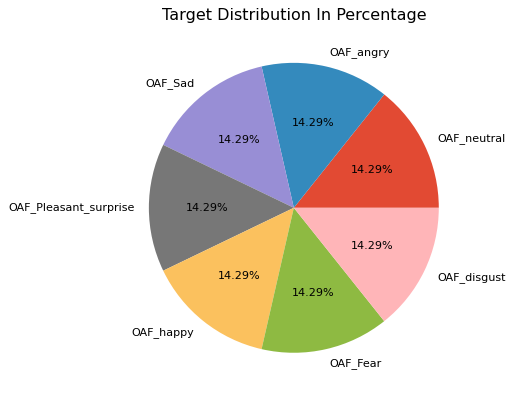

In [27]:
dataset['Label'].value_counts().plot.pie(autopct='%1.2f%%')
plt.title('Target Distribution In Percentage')
plt.ylabel("")
plt.show()

## Dependent Variable Data Preparation

In [28]:
X = []
for m in mfccs_list:
  m = np.mean((m).T, axis=0)
  m = m.reshape(40,1)
  X.append(m)
X = np.array(X)  

## Encoding The Data

In [29]:
Y_df = dataset['Label']
Y_df = pd.DataFrame({'Label':Y_df.values})
Y_df['Label'] = Y_df.Label.astype('category')
Y_df['Label_Code'] = Y_df["Label"].cat.codes
display(Y_df.sample(10))
#{Sad:2, Happy:5, Angry:3, Disgust:4, Fear:0, Suprise:1, Neutral:6}

Label  Label_Code
555   OAF_neutral           6
1147    OAF_happy           5
617   OAF_disgust           4
1043    OAF_happy           5
211      OAF_Fear           0
744   OAF_disgust           4
3       OAF_angry           3
474   OAF_neutral           6
776   OAF_disgust           4
1104    OAF_happy           5

## Converting To Categorical Column

In [30]:
Y = to_categorical(Y_df['Label_Code'])
Y = pd.DataFrame({'Fear': Y[:, 0], 'Suprised': Y[:, 1], 'Sad': Y[:, 2], 'Angry': Y[:, 3], 'Disgust': Y[:, 4], 'Happy': Y[:, 5], 'Neutral': Y[:, 6]})
display(Y.sample(7))

Fear  Suprised  Sad  Angry  Disgust  Happy  Neutral
721    0.0       0.0  0.0    0.0      1.0    0.0      0.0
336    1.0       0.0  0.0    0.0      0.0    0.0      0.0
1008   0.0       0.0  0.0    0.0      0.0    1.0      0.0
902    0.0       1.0  0.0    0.0      0.0    0.0      0.0
532    0.0       0.0  0.0    0.0      0.0    0.0      1.0
413    0.0       0.0  0.0    0.0      0.0    0.0      1.0
401    0.0       0.0  0.0    0.0      0.0    0.0      1.0

## Train and Test Split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

In [32]:
print(f'Train Data => X: {X_train.shape}, Y:{y_train.shape}')
print(f'Test Data => X: {X_test.shape}, Y:{y_test.shape}')

Train Data => X: (1120, 40, 1), Y:(1120, 7)
Test Data => X: (280, 40, 1), Y:(280, 7)


## Model Creation

In [33]:
model = Sequential(name='Model')

model.add(LSTM(128,input_shape=(40,1), return_sequences=True))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(32, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(7, activation='softmax'))

## Model Understanding

In [34]:
model.summary()

Model: "Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 40, 128)           66560     
_________________________________________________________________
activation (Activation)      (None, 40, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128  

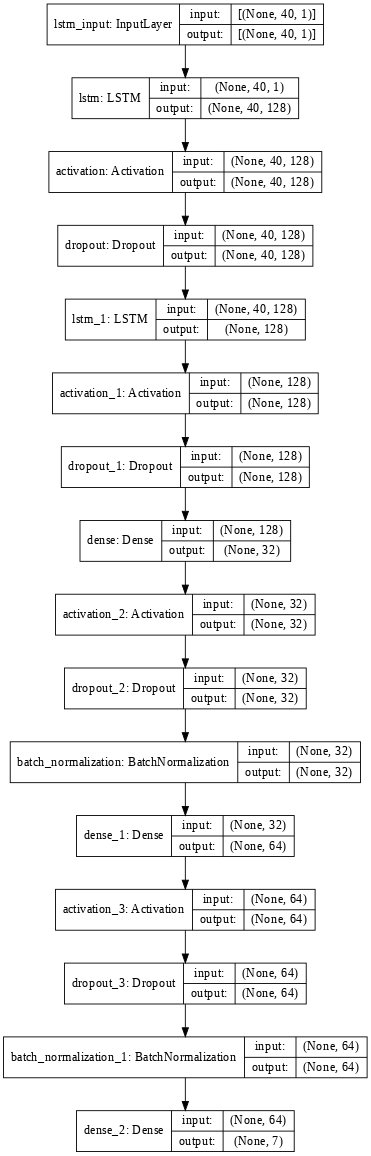

In [35]:
display(plot_model(model, show_shapes=True, show_layer_names=True, dpi=64))

## Model Training

In [36]:
optimizer = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
r = model.fit(X_train, y_train, epochs=33, validation_data=(X_test, y_test))

Epoch 1/33
35/35 [==============================] - 9s 135ms/step - loss: 2.1062 - accuracy: 0.2854 - val_loss: 1.8517 - val_accuracy: 0.3571
Epoch 2/33
35/35 [==============================] - 3s 95ms/step - loss: 1.3000 - accuracy: 0.5113 - val_loss: 1.7921 - val_accuracy: 0.4071
Epoch 3/33
35/35 [==============================] - 3s 96ms/step - loss: 1.1117 - accuracy: 0.5633 - val_loss: 1.7306 - val_accuracy: 0.3429
Epoch 4/33
35/35 [==============================] - 3s 96ms/step - loss: 0.9516 - accuracy: 0.6184 - val_loss: 1.6239 - val_accuracy: 0.5714
Epoch 5/33
35/35 [==============================] - 3s 96ms/step - loss: 0.8822 - accuracy: 0.6547 - val_loss: 1.5220 - val_accuracy: 0.5893
Epoch 6/33
35/35 [==============================] - 3s 96ms/step - loss: 0.7544 - accuracy: 0.7060 - val_loss: 1.4092 - val_accuracy: 0.6000
Epoch 7/33
35/35 [==============================] - 4s 108ms/step - loss: 0.8075 - accuracy: 0.6872 - val_loss: 1.2607 - val_accuracy: 0.6714
Epoch 8/33


## Model Accuracy

In [37]:
import math   
print(f'The traning accuracy of model is {math.floor(r.history["accuracy"][-1] * 100)} %')
print(f'The validation accuracy of model is {math.floor(r.history["val_accuracy"][-1] * 100)} %')

The traning accuracy of model is 92 %
The validation accuracy of model is 94 %


## Model Loss

In [38]:
print(f'The traning loss of model is {r.history["loss"][-1]:.4}')
print(f'The validation loss of model is {r.history["val_loss"][-1]:.4}')

The traning loss of model is 0.2265
The validation loss of model is 0.1292


## Model Loss Visualization

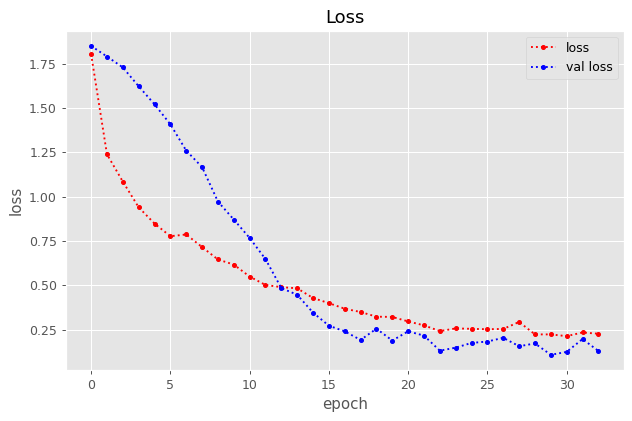

In [39]:
plt.rcParams['figure.dpi'] = 90
plt.rcParams['figure.figsize'] = [8,5]

plt.title('Loss')
plt.plot(r.history['loss'], ".:", label='loss', linewidth=1.5, color="red")
plt.plot(r.history['val_loss'], ".:", label='val loss', linewidth=1.5, color="blue")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

## Model Accuracy Visualization

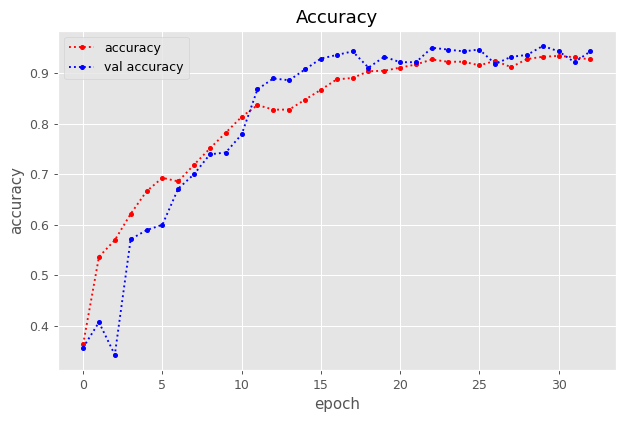

In [41]:
plt.title('Accuracy')
plt.plot(r.history['accuracy'], ".:", label='accuracy', linewidth=1.5, color="red")
plt.plot(r.history['val_accuracy'], ".:", label='val accuracy', linewidth=1.5, color="blue")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

##Saving The Model

In [42]:
model.save('recognizing_emotions_in_speech.h5')